# How To Use The RSRReader Class

This Jupyter Notebook tutorial goes over the different options available with the RSRReader class. In order, the notebook goes over:

>1. Importing RSRReader
>2. Creating an Instance of RSRReader
>3. Extracting SPM and $IQ_m$
>4. Specifying SPM Range to Read File
>5. Resampling Power vs. $IQ_m$
>6. Extracting Sky Frequency
>7. Decimating 16kHz RSR Files to 1kHz frequency


## Importing RSRReader

The RSRReader class is inside of the file "rsr_reader.py". If you're outside of the directory in which you have the code, you can use the sys module to include that directory in the set of paths where Python looks for .py files:

```python
import sys
sys.path.append('/your/path/where/code/is/goes/here')
```

Once you've included the directory of your copy of rsr_reader.py (if necessary), you can import RSRReader like this:

```python
from rsr_reader import RSRReader
```

When imported like this, you can refer to the class simply as `RSRReader`. You can also import it without the `from` part and without saying the class name:

```python
import rsr_reader
```

However, when you do it this way, you have to refer to the class as `rsr_reader.RSRReader` for the rest of your code.

In [1]:
"""

rsr_reader_tutorial.ipynb

Purpose: Go through possible uses of rsr_reader.RSRReader
         class
         
Revisions:
      rsr_reader_tutorial.ipynb
   Apr 11 2018 - gsteranka - Original version
"""

import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample_poly

from rsr_reader import RSRReader

%matplotlib inline

# Path name of RSR file you're reading
rsr_file = '../../../data/s10-rev07-rsr-data/S10EAOE2005_123_0740NNNK34D.1B1'
dt_plt = 0.1

## Creating an Instance of RSRReader

When you create an instance of the RSRReader class, you link it to an RSR file. When you give the RSR file as input, you need to specify the full path name as well as the file. In our case, we defined this as the `rsr_file` variable in the cell above:

```python
rsr_file = '../../../data/s10-rev07-rsr-data/S10EAOE2005_123_0740NNNK34D.1B1'
```

Now all you have to do is use this as input to `RSRReader`:

```python
rsr_inst = RSRReader(rsr_file)
```

In [2]:
rsr_inst = RSRReader(rsr_file)

## Extracting SPM and $IQ_m$

We refer to the raw measured complex signal as $IQ_m$. These are the data from the occultation we use to calculate both power and phase (more on what these are in INSERT NAME OF OTHER NOTEBOOK HERE). For now, we will only deal with power, which we calculate as:

$$P = |IQ_m|^2$$

Although it might be more intuitive to output a set of power values, we choose to output $IQ_m$ because we will later need to calculate phase as well.

In [3]:
spm_raw, IQ_m_raw = rsr_inst.get_IQ()
p_obs_raw = abs(IQ_m_raw)**2

## Specifying SPM Range to Read File

Most of the time, you'll want to just read the entire RSR file. However, you may sometimes want to just read a smaller SPM range. To do this, specify the `spm_range` keyword when extracting SPM and $IQ_m$, as demonstrated in the cell below.

In [4]:
example_spm_range = [30000, 31000]

spm_example_range, IQ_m_example_range = rsr_inst.get_IQ(spm_range=example_spm_range)

print('Full RSR file SPM range:')
print('%10.3f, %10.3f' % (spm_raw[0], spm_raw[-1]))

print('Specified SPM range:')
print('%10.3f, %10.3f' % (spm_example_range[0], spm_example_range[-1]))

Full RSR file SPM range:
 27600.000,  40379.999
Specified SPM range:
 30000.000,  31000.999


## Resampling Power vs. $IQ_m$

In future tutorials, you will see that there are several times at which we will need to resample the data points. For when the time comes, we would like to make an important point here about resampling. To sum it up:

>NEVER RESAMPLE $IQ_m$

To show you exactly why, check out the code in the cell below. In the "Importing RSRReader" section, we defined the time spacing we want to downsample to:

```python
dt_plt = 0.1
```

This lets us select a downsampling coefficient. Then, we go on to resample power in two different ways. In the first, we resample after calculating power in the cell above:

```python
p_obs_plt_GOOD = resample_poly(p_obs_raw, 1, downsample_coef)
```

In the second, we resample $IQ_m$, and then calculate power:

```python
IQ_m_plt_BAD = resample_poly(IQ_m_raw, 1, downsample_coef)
p_obs_plt_BAD = abs(IQ_m_plt_BAD)**2
```

The first resampling method is shown as the left plot (blue) in the cell below, and the second resampling method is shown as the right plot (red). First, notice how different the y-axis ranges are: the blue plot goes up to $~3\times10^8$, while the red plot goes up to only $~8\times10^6$. Not only this, but if you look at the regions where the signal isn't blocked by Saturn ring material (such as 36000 - 40000 SPM), the red plot is substantially lower. You can clearly see that the second resampling method muddles the signal.

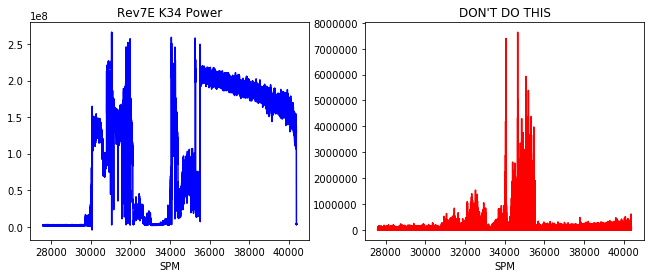

In [5]:
dt_raw = spm_raw[1] - spm_raw[0]
downsample_coef = int(round(dt_plt/dt_raw))

p_obs_plt_GOOD = resample_poly(p_obs_raw, 1, downsample_coef)
spm_plt = spm_raw[0] + dt_plt*np.arange(len(p_obs_plt_GOOD))

IQ_m_plt_BAD = resample_poly(IQ_m_raw, 1, downsample_coef)
p_obs_plt_BAD = abs(IQ_m_plt_BAD)**2

fig1 = plt.figure(1, figsize=(11, 4))

plt.subplot(121)
plt.plot(spm_plt, p_obs_plt_GOOD, 'b')
plt.title('Rev7E K34 Power')
plt.xlabel('SPM')

plt.subplot(122)
plt.plot(spm_plt, p_obs_plt_BAD, 'r')
plt.title('DON\'T DO THIS')
plt.xlabel('SPM')

plt.show()

In the cell below, we illustrate why the two resampling methods yield such different results. In both plots, we zoom in over a very short time range of 0.2 seconds. The left plot shows I at raw resolution (black) and Q at raw resolution (green). The right plot shows the same for the downsampled $IQ_m$ from the cell above, which we used to make the power in the red plot above.

Recall that to produce the right plot, we resampled each curve in the left plot to a much larger time spacing (from 0.001 seconds to 0.1 seconds). Note that in the left plot, both I and Q vary sinusoidally. When you average a sinusoid over one period, you get zero. That's why the curves on the right look so much lower than the curves on the left - when we resampled each part of the complex signal individually, each curve canceled itself out. Then when we calculated power from the resampled I and Q, the resulting power is much lower than the original observed power.

In later tutorials, we will mention frequency correction of $IQ_m$, the result of which we call $IQ_c$. In $IQ_c$, most of the sinusodial variation from each curve has been removed. Throughout the data processing steps, whenever we resample, we resample $IQ_c$.

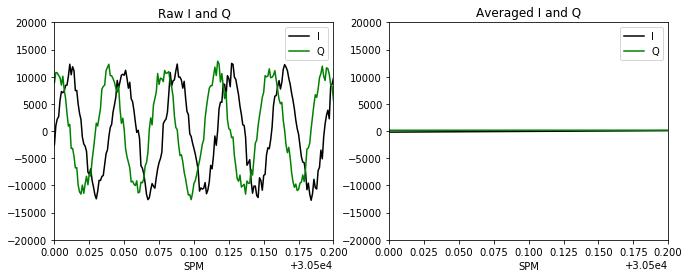

In [6]:
fig2 = plt.figure(2, figsize=(11, 4))

xlim_IQ_plt = [30500, 30500.2]
ylim_IQ_plt = [-20000, 20000]

plt.subplot(121)
I_m_raw_plt ,= plt.plot(spm_raw, np.real(IQ_m_raw), 'k', label='I')
Q_m_raw_plt ,= plt.plot(spm_raw, np.imag(IQ_m_raw), 'g', label='Q')
plt.xlim(xlim_IQ_plt)
plt.ylim(ylim_IQ_plt)
plt.title('Raw I and Q')
plt.xlabel('SPM')
plt.legend()

plt.subplot(122)
I_m_BAD_plt ,= plt.plot(spm_plt, np.real(IQ_m_plt_BAD), 'k', label='I')
Q_m_BAD_plt ,= plt.plot(spm_plt, np.imag(IQ_m_plt_BAD), 'g', label='Q')
plt.xlim(xlim_IQ_plt)
plt.ylim(ylim_IQ_plt)
plt.title('Averaged I and Q')
plt.xlabel('SPM')
plt.legend()

plt.show()

## Extracting Sky Frequency

The RSR file contains a set of polynomial coefficients to evaluate sky frequency, as computed using the spacecraft trajectory predicted before the event. The RSRReader class has a method dedicated to calculating this predicted sky frequency, in which you can either specify what SPM values to evaluate it at or use the default SPM values of 1 second spacing over the full occultation. To use the default SPM values, you can just call the method with no input:

```python
f_spm_default, f_sky_pred_default = rsr_inst.get_f_sky_pred()
```

Alternatively, if you wanted to use the SPM values from the two sets of plots in the cells above (`spm_plt`), you can use that as the input:

```python
f_spm_user, f_sky_pred_user = rsr_inst.get_f_sky_pred(f_spm=spm_plt)
```

In the left plot in the cell below, you can see that either way, the predicted sky frequency curve doesn't look any different.

Because of its smooth structure, it's generally okay to evaluate predicted sky frequency at one set of SPM and later interpolate to another set of SPM if needed. To demonstrate this, we interpolate the predicted sky frequency from the default SPM values to the user-defined SPM values:

```python
f_sky_pred_interp = np.interp(f_spm_user, f_spm_default, f_sky_pred_default)
```

In the right plot, we plot the difference between this and the original user-defined predicted sky frequency. As can be seen, the difference is very minimal - out of a typical sky frequency value of $~10^5$, typical differences don't exceed the order of $~10^{-3}$

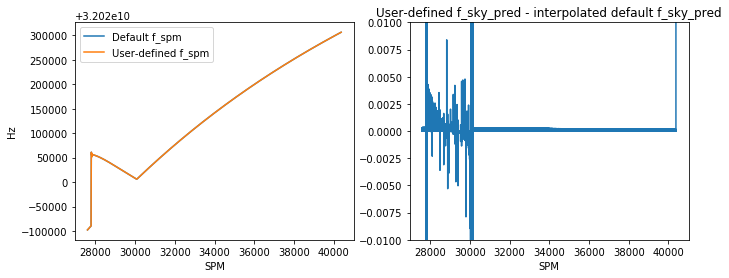

In [7]:
# Evaluate at the default time spacing of 1 second
f_spm_default, f_sky_pred_default = rsr_inst.get_f_sky_pred()

# You can also specify the spm you want to evaluate at
f_spm_user, f_sky_pred_user = rsr_inst.get_f_sky_pred(f_spm=spm_plt)

# Demonstrate that interpolation doesn't change very much
f_sky_pred_interp = np.interp(f_spm_user, f_spm_default, f_sky_pred_default)

fig3 = plt.figure(3, figsize=(11, 4))

plt.subplot(121)
f_sky_default_plt ,= plt.plot(f_spm_default, f_sky_pred_default, label='Default f_spm')
f_sky_user_plt ,= plt.plot(f_spm_user, f_sky_pred_user, label='User-defined f_spm')
plt.xlabel('SPM')
plt.ylabel('Hz')
plt.legend()

plt.subplot(122)
interp_diff_plt ,= plt.plot(f_spm_user, f_sky_pred_user - f_sky_pred_interp)
plt.ylim([-0.01, 0.01])
plt.title('User-defined f_sky_pred - interpolated default f_sky_pred')
plt.xlabel('SPM')

plt.show()

## Decimating 16kHz RSR Files to 1kHz Frequency

So far in this tutorial, we have used a 1kHz RSR file. They tend to give just about the same results, and they're much faster to process. Unfortunately, though, there are only 16kHz files for some wavelength bands and some occultations. Since they take so much longer to process, we offer the option of decimating 16kHz files down to 1kHz frequency in the very beginning when you read the RSR file. This step still often takes a few minutes to complete, but if you're running through the whole set of of processing steps, it still saves a good deal of time and returns nearly the same results.

To do this, all you have to do is specify the keyword `decimate_16khz_to_1khz` as `True` when you call the method to get $IQ_m$. In the cell below, we take the 16kHz file for rev7E X43, select a small spm_range of $IQ_m$ to read, and decimate it to 1kHz. We print out the time spacing in seconds with and without decimation. The new time spacing of $10^{-3}$ seconds makes for a lot less points to process.

In [8]:
rsr_file_16khz = '../../../data/s10-rev07-rsr-data/s10sroe2005123_0740nnnx43rd.2a2'

rsr_inst_16khz = RSRReader(rsr_file_16khz)
spm_range_16khz = [30000, 30500]

spm_16khz, IQ_m_16khz = rsr_inst_16khz.get_IQ(spm_range=spm_range_16khz)

spm_1khz, IQ_m_1khz = rsr_inst_16khz.get_IQ(spm_range=spm_range_16khz,
                                            decimate_16khz_to_1khz=True)

print('Spacing between raw resolution points (seconds):')
print('%10.7f' % (spm_16khz[1] - spm_16khz[0]))

print('Spacing between decimated points (seconds):')
print('%6.3f' % (spm_1khz[1] - spm_1khz[0]))

Spacing between raw resolution points (seconds):
 0.0000625
Spacing between decimated points (seconds):
 0.001
